(60000, 28, 28) (60000, 10)
(10000, 28, 28) (10000, 10)
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
size
(60000, 10) (10000, 10)
356234
total_parameters 356234


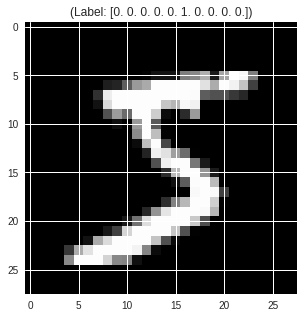

In [18]:
import numpy as np
from keras.utils import np_utils
import matplotlib.pyplot as plt
import tensorflow as tf
mnist = tf.keras.datasets.mnist
tf.reset_default_graph()
n_classes = 10
weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W3', shape=(4*4*128,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W6', shape=(128,n_classes), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(10), initializer=tf.contrib.layers.xavier_initializer()),
}

def conv2d(x, W, b, strides=2):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) 

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')
  
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
print (x_train.shape, y_train.shape)
print (x_test.shape, y_test.shape )

print (y_train)

plt.figure(figsize=[5,5])


curr_img = np.reshape(x_train[0], (28,28))
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str( y_train[0]) + ")")

training_iters = 20 
learning_rate = 0.001   
batch_size = 100

n_classes = 10
train_X = x_train.reshape(-1, 28, 28, 1)
test_X = x_test.reshape(-1,28,28,1)
train_y = y_train
test_y = y_test
print ("size")
print(train_y.shape, test_y.shape)
x = tf.placeholder("float", [None, 28,28,1])
y = tf.placeholder("float", [None, n_classes])
y.shape
keep_prob = tf.placeholder(tf.float32)

def conv_net(x, weights, biases):  

    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)

    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)
    dropout = tf.nn.dropout(conv2, keep_prob)
    conv3 = conv2d(dropout, weights['wc3'], biases['bc3'])
    conv3 = maxpool2d(conv3, k=2)
    
    fully_connected = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fully_connected = tf.add(tf.matmul(fully_connected, weights['wd1']), biases['bd1'])
    fully_connected = tf.nn.relu(fully_connected)
    #drop_out = tf.nn.dropout(fully_connected, keep_prob)
    dropout = tf.nn.dropout(fully_connected, keep_prob)

    out = tf.add(tf.matmul(dropout, weights['out']), biases['out'])
    return out


pred = conv_net(x, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
init = tf.global_variables_initializer()
total_parameters = 0
for variable in tf.trainable_variables():
    # shape is an array of tf.Dimension
    shape = variable.get_shape()

    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
    
print (np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()]) )
print("total_parameters" , total_parameters)












In [19]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(training_iters):
        for batch in range(len(train_X)//batch_size):
            batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
            batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))] 
            opt = sess.run(optimizer, feed_dict={x: batch_x,
                                                              y: batch_y, keep_prob : 0.75})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y, keep_prob : 0.75})
        print("Epoch " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        print("Optimization Finished!")

        test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y, keep_prob : 1.0})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()
    
    

InvalidArgumentError: ignored

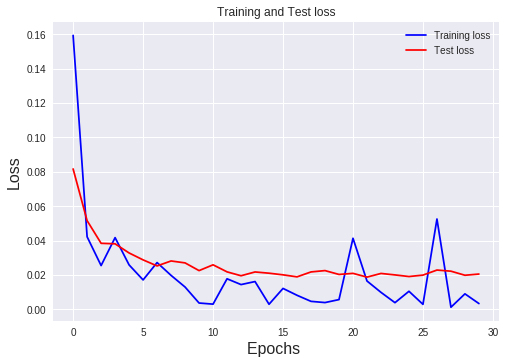

In [9]:
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()


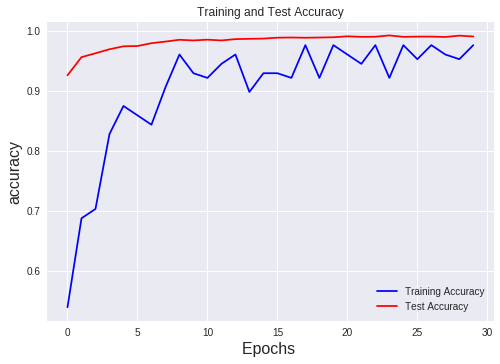

In [5]:
plt.plot(range(len(train_loss)), train_accuracy, 'b', label='Training Accuracy')
plt.plot(range(len(train_loss)), test_accuracy, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('accuracy',fontsize=16)
plt.legend()
plt.figure()
plt.show()